Note book to assess precipitation efficiency in RCE simulations

### Main settings

In [1]:
import numpy as np
import xarray as xr
import subprocess
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns
import pickle
from tqdm.notebook import tqdm_notebook
from scipy import stats

In [2]:
itest_select = 0 # 0 for RCE, 1 for Channel
# itest_select = 1 # 0 for RCE, 1 for Channel

test_set = ['RCE', 'Channel']

tests = [
    'RCE_768_305_snd_newoutput',
    'RCE_768_305_radhomo',
    'ch_rrtm305ri0',
    'ch_rrtm305ri0_radhomo',
    ]
tests_str = [
    'RCE',
    'RCE_RH',
    'channel',
    'channel_radhomo',
    ]

if itest_select == 0:
    itest_plot=(0,1)
else:
    itest_plot=(2,3)

# Set date ranges for data read

# day_bounds = (10,20)
# day_bounds = (30,60)
if itest_select == 0:
    day_bounds = (1,100)
    # day_bounds = (90,100) # Extra variables written out for this time slice
    # day_bounds = (10,20) # Extra variables written out for this time slice
    delta=0
elif itest_select == 1:
    day_bounds = (1,65)
    delta=-80.5

do_2d_plots = True # 3-panel plots
do_2d_plots = False # 3-panel plots

# Write pickle files?
do_readwrite = True
do_readwrite = False

# Read extra 3D variables?
save_extra = True
save_extra = False

### Read functions

In [3]:
datdir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/jruppert/wing_rce/'
pickle_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/jruppert/wing_rce/pickle_out/'

# RCE square domain sims:
#   control: 24 3D files per day
#   radhomo: 4 3D files per day
# 
# Channel domain sims:
#   julian day starts at 80.5 but this is the actual start of simulation
#   runs out to 148-80.5 = 67.5 days

# 300 # seconds per timestep (= 5 min)
# 300*24 # label numbers

all_3d_files = {}
for itest, isim in enumerate(tests):
    process = subprocess.Popen(['ls '+datdir+isim+'/NC_files/OUT_3D/*nc'],shell=True,
        stdout=subprocess.PIPE,universal_newlines=True)
    files = process.stdout.readlines()
    nfiles = len(files)
    # print(nfiles)
    for ifil in range(nfiles):
        files[ifil] = files[ifil].strip()
    all_3d_files[tests_str[itest]] = files

In [4]:
def get_times_files(file_tmp, times, files):
    try:
        ds = xr.open_dataset(file_tmp)
        times.append(ds['time'].squeeze().values + delta)
        files.append(file_tmp)
        ds.close()
    except:
        pass
    return times, files

# nfpday = 4
# ifile_set = np.arange(day_bounds[0], day_bounds[1] + 1/nfpday, 1/nfpday)*nfpday - 1*nfpday
# dt = 1/24
dt = 1/4
ifile_set = np.arange(day_bounds[0], day_bounds[1] + dt, dt)
file_num_tag = ifile_set*300*24 # label numbers
nfiles = len(ifile_set)

times_3d = []
times_3d_rh = []
files_3d = []
files_3d_rh = []
for iifile in range(nfiles):
    itest=itest_plot[0]
    file_tmp = all_3d_files[tests_str[itest]][0][:-13] + str(int(file_num_tag[iifile])).zfill(10) + '.nc'
    times_3d, files_3d = get_times_files(file_tmp, times_3d, files_3d)
    itest=itest_plot[1]
    file_tmp = all_3d_files[tests_str[itest]][0][:-13] + str(int(file_num_tag[iifile])).zfill(10) + '.nc'
    times_3d_rh, files_3d_rh = get_times_files(file_tmp, times_3d_rh, files_3d_rh)
times_3d = np.array(times_3d)
times_3d_rh = np.array(times_3d_rh)
nt = len(times_3d)
nt_rh = len(times_3d_rh)
print(nt)
print(nt_rh)

rce_3d = xr.open_dataset(files_3d[0])
x = rce_3d.coords['x'].values/1e3 # km
y = rce_3d.coords['y'].values/1e3 # km
z = rce_3d.coords['z'].values/1e3 # km
nx = rce_3d.coords['x'].size
ny = rce_3d.coords['y'].size
nz = rce_3d.coords['z'].size
rce_3d.close()

# times_3d = []
# for iifile in [all_3d_files[tests_str[0]][iff] for iff in range(1000,1196)]:
#     # ifile = round(ifile_set[iifile])
#     itest=itest_plot[0]
#     file_tmp = iifile
#     try:
#         ds = xr.open_dataset(file_tmp)
#         times_3d.append(ds['time'].squeeze().values)
#         ds.close()
#         files_3d.append(file_tmp)
#     except:
#         continue
# times_3d = np.array(times_3d)
# nt = len(times_3d)
# print(times_3d)

# print(times_3d)
# print()
# print(times_3d_rh)

397
397


#### 2D read functions

In [5]:
# Find matching time steps and read 2D files

def get_sfc_variables(itest_plot, day_bounds):

    if itest_plot[0] == 0:
        if day_bounds[0] < 42:
            rce_2d    = xr.open_dataset(datdir+tests[0]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_1.nc')
            rce_2d_rh = xr.open_dataset(datdir+tests[1]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_1.nc')
        elif day_bounds[0] < 84:
            rce_2d    = xr.open_dataset(datdir+tests[0]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_2.nc')
            rce_2d_rh = xr.open_dataset(datdir+tests[1]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_2.nc')
        else:
            rce_2d    = xr.open_dataset(datdir+tests[0]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_3.nc')
            rce_2d_rh = xr.open_dataset(datdir+tests[1]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_3.nc')
    elif itest_plot[0] == 2:
        if day_bounds[0] < 43:
            rce_2d    = xr.open_dataset(datdir+tests[2]+'/NC_files/OUT_2D/ch_rrtm305ri0_4096x64x64_3km_12s_rrtm305ri0_64.2Dcom_1.nc')
            rce_2d_rh = xr.open_dataset(datdir+tests[3]+'/NC_files/OUT_2D/ch_rrtm305ri0_radhomo_4096x64x64_3km_12s_rrtm305ri0_radhomo_64.2Dcom_1.nc')
        else:
            rce_2d    = xr.open_dataset(datdir+tests[2]+'/NC_files/OUT_2D/ch_rrtm305ri0_4096x64x64_3km_12s_rrtm305ri0_64.2Dcom_2.nc')
            rce_2d_rh = xr.open_dataset(datdir+tests[3]+'/NC_files/OUT_2D/ch_rrtm305ri0_radhomo_4096x64x64_3km_12s_rrtm305ri0_radhomo_64.2Dcom_2.nc')

    imatch = np.where((rce_2d['time'] > times_3d[0]) & (rce_2d['time'] < times_3d[-1]))[0]
    imatch = []
    for it in times_3d:
        imatch.append(np.where((rce_2d['time'] == it))[0][0])
    imatch = np.array(imatch)

    imatch_rh = np.where((rce_2d_rh['time'] > times_3d_rh[0]) & (rce_2d_rh['time'] < times_3d_rh[-1]))[0]
    imatch_rh = []
    for it in times_3d_rh:
        imatch_rh.append(np.where((rce_2d_rh['time'] == it))[0][0])
    imatch_rh = np.array(imatch_rh)

    def read_vars(ds, imatch):
        vars={}
        lwns   = ds['LWNS'][imatch,:,:].values
        lwnsc  = ds['LWNSC'][imatch,:,:].values
        lwnt   = ds['LWNT'][imatch,:,:].values
        lwntc  = ds['LWNTC'][imatch,:,:].values
        lw_acre_t = lwnt - lwntc
        lw_acre_s = lwns - lwnsc
        lwacre = lw_acre_s - lw_acre_t
        vars['lwacre'] = lwacre
        vars['iwp'] = ds['IWP'][imatch,:,:].values
        vars['lwp'] = ds['CWP'][imatch,:,:].values
        vars['pw'] = ds['PW'][imatch,:,:].values
        vars['rain'] = ds['Prec'][imatch,:,:].values # mm/d
        return vars

    vars2d = read_vars(rce_2d, imatch)
    vars2d_rh = read_vars(rce_2d_rh, imatch_rh)

    rce_2d.close()
    rce_2d_rh.close()

    return vars2d, vars2d_rh

#### 3D read functions

In [6]:
# Functions for reading 3D variables

def precip_class(q_int):

    shape = q_int.shape
    ndims=len(shape)
    shape_out = shape[1:ndims]

    # Integrated water variables
    LWP = q_int[0] + q_int[1]               # Liquid water path = cloud + rain
    IWP = q_int[2] + q_int[3] + q_int[4]    # Ice water path = ice + snow + graupel
    TWP = LWP + IWP                         # Total water path [mm]

    IWP = np.ma.masked_where((LWP == 0), IWP, copy=False)

    # Threshold p]arameters
    twp_thresh = 1e-1
    cr_thresh = 2
    # ice_thresh = 1e-8
    graup_thresh = 1e-4
    rain_thresh_conv = 1e-1
    rain_thresh_strat = 1e-2

    # Initialize output array
    if np.ma.is_masked(q_int):
        c_type = np.ma.zeros(shape_out, dtype=np.int8)
        domask=True
    else:
        c_type = np.zeros(shape_out, dtype=np.int8)
        domask=False

    cr = IWP/LWP

    # Deep convection
    c_type[( ((LWP != 0) & (TWP > twp_thresh)) &
            (cr <= cr_thresh) &
            (q_int[1] >= rain_thresh_conv) &
            (q_int[4] >= graup_thresh) ).nonzero() ] = 1
    # Congestus
    c_type[( ((LWP != 0) & (TWP > twp_thresh)) &
            (cr <= cr_thresh) &
            (q_int[1] >= rain_thresh_conv) &
            (q_int[4] < graup_thresh) ).nonzero() ] = 2
    # Shallow
    c_type[( ((LWP != 0) & (TWP > twp_thresh)) &
            (cr <= cr_thresh) &
            (q_int[1] < rain_thresh_conv) ).nonzero() ] = 3
    # Stratiform
    c_type[( ((LWP != 0) & (TWP > twp_thresh)) &
            (cr > cr_thresh) &
            (q_int[1] >= rain_thresh_strat) ).nonzero() ] = 4
    # Anvil
    c_type[( ((LWP != 0) & (TWP > twp_thresh)) &
            (cr > cr_thresh) &
            (q_int[1] < rain_thresh_strat) ).nonzero() ] = 5

    # Fill in mask of original array if it exists
    if domask:
        c_type.mask = q_int.mask[0,...]

    return c_type

def get_q_cloud(T, qn, qp):
    qcloud = np.maximum(0,np.minimum(1,(T-253.16)/20))*qn # %cloud water kg/kg
    qice   = (1-np.maximum(0,np.minimum(1,(T-253.16)/20)))*qn # %cloud ice kg/kg
    qrain  = np.maximum(0,np.minimum(1,(T-268.16)/15))*qp # %precipitating water kg/kg
    # qsnow  = (1-np.maximum(0,np.minimum(1,(T-268.16)/15)))*qp # %precipitating ice kg/kg
    qsnow = (1-np.maximum(0,np.minimum(1,(T-268.16)/15))*(1-np.maximum(0,np.minimum(1,(T-223.16)/(60)))))*qp # snow g/g
    qgraupel = (1-np.maximum(0,np.minimum(1,(T-268.16)/15))*np.maximum(0,np.minimum(1,(T-223.16)/(60))))*qp # graupel g/g

    return qcloud, qice, qrain, qsnow, qgraupel

def get_dse(tmpk):
    # Constants
    cp=1004. # J/K/kg
    g=9.81 # m/s2
    # Dry static energy (DSE)
    dse = cp*tmpk + g*z[:,np.newaxis,np.newaxis]*1e3 # J/kg
    return dse

def get_3d_vars(files, save_extra=False):

    nt = len(files)
    vmf = np.zeros((nt, ny, nx))
    wu_sav = np.zeros((nt, ny, nx))
    wd_sav = np.zeros((nt, ny, nx))
    pclass = np.zeros((nt, ny, nx))
    if save_extra:
        w_sav = np.zeros((nt, nz, ny, nx))
        dse = np.zeros((nt, nz, ny, nx))
        qrad_sav = np.zeros((nt, nz, ny, nx))

    for it, file in enumerate(tqdm_notebook(files)):

        ds = xr.open_dataset(file)

        # Precipitating and non-precipitating condensate
        qn = ds['QN'].squeeze().values*1e-3 # g/kg --> kg/kg
        qp = ds['QP'].squeeze().values*1e-3 # g/kg --> kg/kg
        tmpk = ds['TABS'].squeeze().values # K

        p0 = ds['p'].squeeze().values*1e2 # Pa
        pres = p0[:,np.newaxis,np.newaxis] + ds['PP'].squeeze().values # Pa

        w = ds['W'].squeeze().values # m/s

        if save_extra:
            w_sav[it] = w
            dse[it] = get_dse(tmpk) # J/kg
            try:
                qrad_sav[it] = ds['QRAD'].squeeze().values # K/d
            except:
                pass

        ds.close()

        g = 9.81 # m/s2
        dp = np.gradient(pres, axis=0)*-1 # Pa

        # Get vertically integrated cloud variables
        qcloud, qice, qrain, qsnow, qgraupel = get_q_cloud(tmpk, qn, qp)
        q_int = []
        for iq in [qcloud, qrain, qice, qsnow, qgraupel]:
            q_int.append(np.sum(iq*dp/g, axis=0))
        q_int = np.array(q_int)
        pclass[it] = precip_class(q_int)

        vars = {}

        wu = np.where((w > 0), w, 0)
        wd = np.where((w < 0), w, 0)
        p_top = 100e2 # Pa
        # k_vint_top = np.where(pres == vint_top)[0][0]
        vmf[it] = np.sum(w*dp/g, axis=0, where=(pres >= p_top)) # kg/m/s
        wu_sav[it] = np.sum(wu*dp/g, axis=0, where=(pres >= p_top)) # kg/m/s
        wd_sav[it] = np.sum(wd*dp/g, axis=0, where=(pres >= p_top)) # kg/m/s

    vars['vmf'] = vmf
    vars['vmfu'] = wu_sav
    vars['vmfd'] = wd_sav
    vars['pclass'] = pclass
    if save_extra:
        vars['w'] = w_sav
        vars['dse'] = dse
        vars['qrad'] = qrad_sav

    return vars

### Main read/write block

In [7]:
# Read in all variables

pickle_file = pickle_dir+test_set[itest_select]+'_days_'+str(times_3d[0])+'_'+str(times_3d[-1])+'.pickle'
pickle_file_2d = pickle_dir+test_set[itest_select]+'_days_'+str(times_3d[0])+'_'+str(times_3d[-1])+'_2d.pickle'

if do_readwrite:

    if do_2d_plots:
        pickle_out_2d = {}
        vars2d, vars2d_rh = get_sfc_variables(itest_plot, day_bounds)
        pickle_out_2d['vars2d'] = vars2d
        pickle_out_2d['vars2d_rh'] = vars2d_rh
        # Save variables to pickle
        with open(pickle_file_2d, 'wb') as f:
            pickle.dump(pickle_out_2d, f)

    pickle_out = {}
    vars3d = get_3d_vars(files_3d, save_extra=save_extra)
    vars3d_rh = get_3d_vars(files_3d_rh, save_extra=save_extra)
    pickle_out['vars3d'] = vars3d
    pickle_out['vars3d_rh'] = vars3d_rh
    # Save variables to pickle
    with open(pickle_file, 'wb') as f:
        pickle.dump(pickle_out, f)

else:

    # Read in variables from pickle
    with open(pickle_file, 'rb') as f:
        pickle_in = pickle.load(f)
        vars3d = pickle_in['vars3d']
        vars3d_rh = pickle_in['vars3d_rh']
    # Read in variables from pickle
    if do_2d_plots:
        with open(pickle_file_2d, 'rb') as f:
            pickle_in = pickle.load(f)
            vars2d = pickle_in['vars2d']
            vars2d_rh = pickle_in['vars2d_rh']


### Vertical motion analysis

In [8]:
# Plot mean W profiles

analyze_w = True
analyze_w = False

if analyze_w:


    # Plot profiles of mean w as a way to test classification

    def plot_w_profiles(ivars, z):
        fig, ax = plt.subplots(1, 1, figsize=(4, 6))
        # Change the colormap
        cmap = sns.color_palette("tab10", 6)
        # Plot zero-line
        ax.axvline(0, color='k', lw=1, ls='-')
        for ipclass in [0, 1, 2, 3, 4, 5]:
            wprof = np.zeros_like(ivars['w'][:,:,0,0])
            ind = (ivars['pclass'] == ipclass).nonzero()
            # Number of points in each class
            nclass = len(ind[0])
            wprof = np.mean(ivars['w'][ind[0],:,ind[1],ind[2]], axis=0)
            ax.plot(wprof, z, label=str(ipclass)+' n='+str(nclass), color=cmap[ipclass], linewidth=1.5)

        ind = ((ivars['pclass'] == 1) | (ivars['pclass'] == 4)).nonzero()
        # Number of points in each class
        nclass = len(ind[0])
        wprof = np.mean(ivars['w'][ind[0],:,ind[1],ind[2]], axis=0)
        ax.plot(wprof, z, label=str(ipclass)+' n='+str(nclass), color='black', linewidth=1.5, ls='--')

        ax.set_xlabel('W [m/s]')
        ax.set_ylabel('z [km]')
        ax.set_title('W profiles')
        ax.legend(fontsize=8)
        ax.set_ylim(0, 17)
        plt.tight_layout()
        plt.show()
        plt.close()
        return None

    # Plot W profiles
    plot_w_profiles(vars3d, z)
    # plot_w_profiles(vars3d_rh, z)

### Plot precip. effic.

In [9]:
def get_plot_vars(vars_3d):

    nt = vars_3d['vmf'].shape[0]

    # iwhere = np.where((vars_3d['pclass'] == 1) | (vars_3d['pclass'] == 4) | (vars_3d['pclass'] == 5))
    # var = (1 - (-vars_3d['vmfd']/vars_3d['vmfu']))[iwhere]

    vmfu = np.zeros(nt)
    vmfd = np.zeros(nt)
    for it in range(nt):
        # ind = ((vars_3d['pclass'][it] == 1) | (vars_3d['pclass'][it] == 4)).nonzero()
        ind = ((vars_3d['pclass'][it] == 1) | (vars_3d['pclass'][it] == 4) | (vars_3d['pclass'][it] == 5)).nonzero()
        # ind = ((vars_3d['pclass'][it] == 1) | (vars_3d['pclass'][it] == 2) | (vars_3d['pclass'][it] == 3)).nonzero()
        # ind = ((vars_3d['pclass'][it] == 1)).nonzero()
        vmfu[it] = np.mean(vars_3d['vmfu'][it][ind])
        vmfd[it] = np.mean(vars_3d['vmfd'][it][ind])
    var = (1 - (-vmfd/vmfu))
    title = r'$\epsilon = 1 - M_d / M_u$'
    units = '-'

    return var.flatten(), units, title

10.0 30.0
10.0 30.0
80.0 100.0
80.0 100.0


/tmp/ipykernel_6327/202714176.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


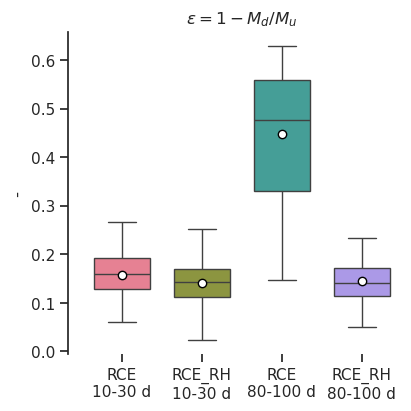

In [10]:
def histogram_plot(vars3d, vars3d_rh):
    # sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
    sns.set_theme(style="ticks", rc={'xtick.bottom': True, 'ytick.left': True})#, "axes.spines.right": False, "axes.spines.top": False})
    # sns.set_theme(style="dark")

    fig_x = 4
    fig_y = 4
    fig, ax = plt.subplots(1,1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
    # ax.set_ylabel('Density')
    # ax.set_xlabel('kg/m$^2$')

    # Read full variable
    ivar, units, title = get_plot_vars(vars3d)
    ivar_rh, units, title = get_plot_vars(vars3d_rh)
    ivar_all_sav = [ivar, ivar_rh]

    # Create subset for two different time intervals
    ivar_sav = []
    labels = []
    for i, (ivar, legend) in enumerate(zip(ivar_all_sav, tests_str[0:2])):
        # Time 1
        # d_sel = (0, 19*4)
        d_sel = (9*4, 29*4)
        print(times_3d[d_sel[0]], times_3d[d_sel[1]])
        time_str = str(int(times_3d[d_sel[0]]))+'-'+str(int(times_3d[d_sel[1]]))+' d'
        ivar_sav.append(ivar[d_sel[0]:d_sel[1]])
        labels.append(legend + '\n'+time_str)
    for i, (ivar, legend) in enumerate(zip(ivar_all_sav, tests_str[0:2])):
        # Time 2
        d_sel = (-(20*4+1), -1)
        print(times_3d[d_sel[0]], times_3d[d_sel[1]])
        time_str = str(int(times_3d[d_sel[0]]))+'-'+str(int(times_3d[d_sel[1]]))+' d'
        ivar_sav.append(ivar[d_sel[0]:d_sel[1]])
        labels.append(legend + '\n'+time_str)

    # kde = sns.kdeplot(ivar, ax=ax, label=legend, fill=True, common_norm=True, color=default_colors[i])
    cmap = ['teal', 'plum',]# 'darkorange', 'gold', 'cornflowerblue']
    sns.set_palette(cmap, n_colors=2)
    sns.boxplot([ivar_sav[ic] for ic in range(4)],
                width=0.7, showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"})
    ax.set_xticklabels(labels)
    sns.despine(offset=10,ax=ax, left=False, bottom=True)
    plt.ylabel(units)
    plt.title(title)
    plt.show()
    plt.close()
    return None

histogram_plot(vars3d, vars3d_rh)

10.0 30.0
80.0 100.0


/tmp/ipykernel_6327/2545450985.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


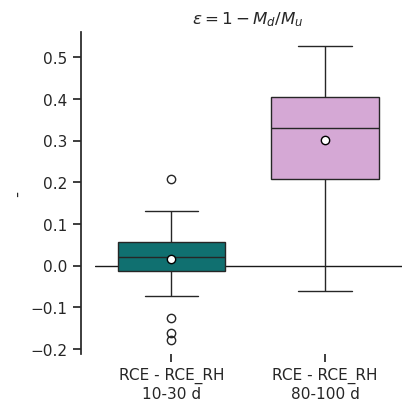

In [11]:
def histogram_plot_v2(vars3d, vars3d_rh):
    # sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
    sns.set_theme(style="ticks", rc={'xtick.bottom': True, 'ytick.left': True})#, "axes.spines.right": False, "axes.spines.top": False})
    # sns.set_theme(style="dark")

    fig_x = 4
    fig_y = 4
    fig, ax = plt.subplots(1,1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
    # ax.set_ylabel('Density')
    # ax.set_xlabel('kg/m$^2$')

    # Read full variable
    ivar, units, title = get_plot_vars(vars3d)
    ivar_rh, units, title = get_plot_vars(vars3d_rh)
    ivar_all_sav = [ivar, ivar_rh]

    # Create subset for two different time intervals
    ivar_sav = []
    labels = []
    # Time 1
    # d_sel = (0, 19*4)
    d_sel = (9*4, 29*4)
    print(times_3d[d_sel[0]], times_3d[d_sel[1]])
    time_str = str(int(times_3d[d_sel[0]]))+'-'+str(int(times_3d[d_sel[1]]))+' d'
    ivar_sav.append((ivar_all_sav[0] - ivar_all_sav[1])[d_sel[0]:d_sel[1]])
    labels.append(tests_str[0]+' - '+tests_str[1] + '\n'+time_str)
    # Time 2
    d_sel = (-(20*4+1), -1)
    print(times_3d[d_sel[0]], times_3d[d_sel[1]])
    time_str = str(int(times_3d[d_sel[0]]))+'-'+str(int(times_3d[d_sel[1]]))+' d'
    ivar_sav.append((ivar_all_sav[0] - ivar_all_sav[1])[d_sel[0]:d_sel[1]])
    labels.append(tests_str[0]+' - '+tests_str[1] + '\n'+time_str)

    # kde = sns.kdeplot(ivar, ax=ax, label=legend, fill=True, common_norm=True, color=default_colors[i])
    cmap = ['teal', 'plum',]# 'darkorange', 'gold', 'cornflowerblue']
    sns.set_palette(cmap, n_colors=2)
    sns.boxplot([ivar_sav[ic] for ic in range(2)],
                width=0.7, showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"})
    ax.set_xticklabels(labels)
    ax.axhline(0, color='k', lw=1, ls='-', zorder=0)
    sns.despine(offset=10,ax=ax, left=False, bottom=True)
    plt.ylabel(units)
    plt.title(title)
    plt.show()
    plt.close()
    return None

histogram_plot_v2(vars3d, vars3d_rh)

In [12]:
# Function to compute running mean
def running_mean_conf(time_series):
    nd_smooth = 6 # days
    ntpday = 4 # timesteps per day
    window_size = nd_smooth*ntpday  # Adjust as needed
    tser_smooth = np.convolve(time_series, np.ones(window_size) / window_size, mode='valid')
    # Compute standard error of the mean
    standard_error = stats.sem(time_series)  # Standard error of the original data
    confidence_interval = 1.96 * standard_error  # 95% confidence interval
    return tser_smooth, confidence_interval, window_size

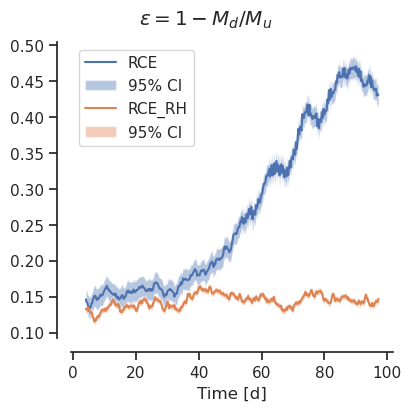

In [13]:
# Plot line plot with PE for both tests
def line_plot(vars3d, vars3d_rh):
    # sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
    sns.set_theme(style="ticks", rc={'xtick.bottom': True, 'ytick.left': True})#, "axes.spines.right": False, "axes.spines.top": False})
    # sns.set_theme(style="dark")
    fig_x = 4
    fig_y = 4
    fig, ax = plt.subplots(1,1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
    title = r'$\epsilon = 1 - M_d / M_u$'
    plt.suptitle(title)
    for i, (vars_3d, legend) in enumerate(zip([vars3d, vars3d_rh], tests_str[0:2])):
        ivar, units, title = get_plot_vars(vars_3d)
        ivar_smooth, confidence_interval, nwindow = running_mean_conf(ivar)
        # ax.plot(times_3d, ivar, label=legend, linewidth=1.5)
        x_smoothed = times_3d[nwindow//2:-nwindow//2+1]
        ax.plot(x_smoothed, ivar_smooth, label=legend, linewidth=1.5)
        plt.fill_between(x_smoothed,
            ivar_smooth - confidence_interval,
            ivar_smooth + confidence_interval,
            alpha=0.4,label="95% CI",)
    sns.despine(offset=10,ax=ax)#, left=True, bottom=True)
    # ax.spines['left'].set_visible(False)
    ax.set_xlabel('Time [d]')
    plt.legend()
    plt.show()
    plt.close()
    return None

line_plot(vars3d, vars3d_rh)

In [14]:
def create_3panel(ivars2d, ivars3d, times, itime):

    fig, axs = plt.subplots(1, 3, figsize=(12, 8))

    # Plot cloud class

    title = 'Cloud Class, '+str(times[itime])+' d'

    pclass_plt = ivars3d['pclass'][itime]
    bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5])
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=6)
    nlevs = len(bounds) - 1
    cmap = plt.get_cmap('Accent_r', nlevs)
    axs[0].pcolormesh(x, y, pclass_plt, cmap=cmap, norm=norm)
    axs[0].set_title(title)
    axs[0].set_xlabel('[km]')
    axs[0].set_ylabel('[km]')
    axs[0].set_aspect('equal')
    cbar = fig.colorbar(axs[0].collections[0], ax=axs[0], fraction=0.03, pad=0.015, ticks=(0,1,2,3,4,5), shrink=0.8)
    cbar.set_ticklabels(['NR', 'DC', 'Cg', 'Sh', 'St', 'An'])

    norm=None

    clevs = np.arange(0.001,0.1,.005)
    clevs2 = np.arange(0.001,0.1,0.005)

    # Plot CWP + IWP overlaid

    title = "CWP (gray) + IWP (red)"
    units = '[mm]'

    pltvar_cwp = ivars2d['lwp'][itime]
    pltvar_iwp = ivars2d['iwp'][itime]
    axs[1].contourf(x, y, pltvar_cwp, cmap='Greys', alpha=0.8, norm=colors.LogNorm(vmin=1e-2))
    axs[1].contourf(x, y, pltvar_iwp, cmap='Reds', alpha=0.55, norm=colors.LogNorm(vmin=1e-2))
    axs[1].set_title(title)
    axs[1].set_xlabel('[km]')
    axs[1].set_aspect('equal')
    fig.colorbar(axs[1].collections[0], ax=axs[1], fraction=0.03, pad=0.03, shrink=0.8, label=units)

    # Plot LW ACRE

    title = "LW ACRE"
    units = '[W/m$^2$]'

    pltvar = ivars2d['lwacre'][itime]
    axs[2].contourf(x, y, pltvar, cmap='RdGy_r', extend='both', norm=colors.TwoSlopeNorm(vcenter=0, vmin=-20, vmax=150))
    axs[2].set_title(title)
    axs[2].set_xlabel('[km]')
    axs[2].set_aspect('equal')
    fig.colorbar(axs[2].collections[0], ax=axs[2], fraction=0.03, pad=0.03, shrink=0.8, label=units)

    plt.tight_layout()
    plt.show()
    plt.close()
    return None

In [15]:
if do_2d_plots:
    itime = 30
    create_3panel(vars2d, vars3d, times_3d, itime)
    create_3panel(vars2d_rh, vars3d_rh, times_3d_rh, itime)